In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [76]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [77]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [78]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [79]:
# reflect an existing database into a new model (ORM Class)
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [80]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [81]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [82]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [83]:
#inspect the engine
inspector=inspect(engine)

In [84]:
#collect the names of the tables

inspector.get_table_names()



['measurement', 'station']

In [85]:
#looking at the column names and types 'measurement' table
columns_m=inspector.get_columns('measurement')
for column in columns_m:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [86]:
#looking at the columns names and types in 'station' table
columns_s=inspector.get_columns('station')
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [100]:
#Looking at the data
results=engine.execute ('select * from Measurement limit 5')
for result in results:
        print(result)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


# Exploratory Precipitation Analysis

In [113]:
# Find the most recent date in the data set.
most_recent=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]


print(most_recent)
type(most_recent)

2017-08-23


str

In [118]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. (previous cell)

#convert most recent date to datetime format, now called dt_most_recent
dt_most_recent= dt.datetime.strptime(most_recent, "%Y-%m-%d")
dt_most_recent

datetime.datetime(2017, 8, 23, 0, 0)

In [115]:
# Calculate the date one year from the last date in data set.
dt_first_date=dt_most_recent-dt.timedelta(days=365)
dt_first_date

datetime.datetime(2016, 8, 23, 0, 0)

In [ ]:
# Perform a query to retrieve the data and precipitation scores
precip_query=(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>dt_first_date).order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df=pd.DataFrame(precip_query,columns= ["Date", "Precipitation"])
precip_df["Date"] = pd.to_datetime(precip_df["Date"])
precip_df= precip_df.sort_values("Date").dropna().set_index("Date")
precip_df.head()

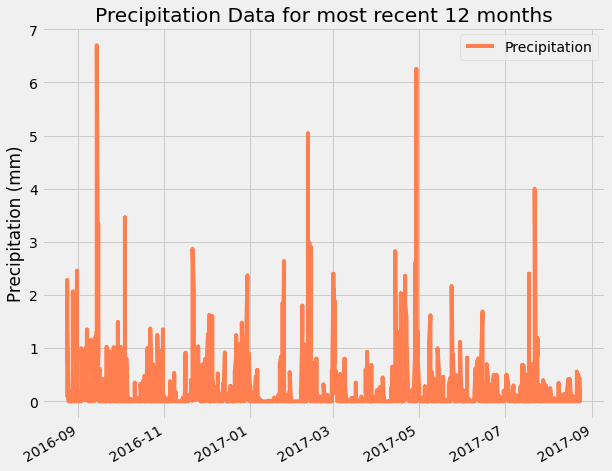

In [137]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(color="coral", figsize=(9, 8))
plt.title("Precipitation Data for most recent 12 months")
plt.ylabel("Precipitation (mm)")
plt.xlabel("")
plt.savefig("Images/precip.png")

In [135]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()